In [1]:
%load_ext autoreload
%autoreload 2

# Отслеживаем тренды

Вы опять разработчик рекомендательной системы в пекарне "Хлеб и корочка"! У вас есть десять видов хлеба, и при входе на сайт пекарни вы предлагаете пользователю один из них (предлагаем начать с одного, а потом попробуем рекомендовать три). Если пользователь увидит на баннере хлеб, который ему нравится, он с большой вероятностью его купит (оставит положительный отклик на рекомендацию). **Мы изучили предпочтения пользователей и выяснили, что предпочтения пользователей меняются со временем. Какие-то виды хлеба становятся менее популярными, а популярность других растет.** Рекомендательная система пекарни должна учитывать эти изменения, чтобы быть эффективной. У нас нет информации о товарах (хлебе) и пользователях, кроме их идентификаторов (id). Вам нужно обучить рекомендательную модель, максимизирующую количество купленных товаров. У вас нет исторических данных, но доступен симулятор, генерирующий отклики пользователей на рекомендации, который поможет получить данные в интерактивном режиме.


### Пользователи
5000 анонимных пользователей

### Товары
10 видов хлеба

### Модель отклика пользователя на товары
Пользователи выбирают "популярные" виды хлеба. Популярность меняется со временем, которое определяется номером итерации. Пользователи покупают товары только из рекомендаций, по одной штуке и могут покупать те же самые товары при повторном посещении сервиса.

### Задача
Построить рекомендательную систему, которая обеспечит наибольшее количество покупок товаров на пользователя

### Доступные данные
Пользователи будут реагировать на ваши рекомендации в интерактивном режиме. Вы получаете список пользователей, для каждого из которых нужно подготовить по 1-3 рекомендаций. Модель отклика симулятора генерирует отклики на рекомендации, которые вы можете использовать для обучения рекомендательной системы. Мы не "прячем" от вас модель отклика, но просим не использовать ее и данные, которые она использует, в своем решении. В данной задаче вы не обладаете никакой информацией о пользователях и товарах, кроме их идентификаторов.

### Особенности задачи
Если переходить к классической RL-постановке, наша рекомендательная система становится агентом, который выбирает одно из возможных действий (товаров для рекомендации пользователю), и действует в среде, определяемой пользователями, товарами, их признаками и предыдущей историей взаимодействия. В задаче рекомендаций часто есть большое количество пользователей, которые могут реагировать на рекомендации отложенно, поэтому мы будем работать в batch-режиме (строить рекомендации для группы пользователей одновременно и получать отклики на все построенные рекомендации одновременно). Также мы попробуем рекомендовать более одного товара за раз.


## Импорты и настройки

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

In [3]:
!pip list | grep "replay"

replay-rec                    0.10.0      /home/anna/airi_summer_school23/RePlay


In [4]:
import random
import time

import pandas as pd
import numpy as np

import pyspark.sql.functions as sf
from pyspark import SparkConf
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession

from replay.models import UCB
from replay.session_handler import State
from replay.utils import get_top_k_recs

# укажите путь к tmp-папке spark и директории с чекпоинтами симулятора.
SPARK_LOCAL_DIR = './tmp/task_3'
CHECKPOINT_DIR = './tmp/task_3_checkpoints'

In [5]:
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import Simulator

from response_models.task_3_popular_items_drift import TaskThreeResponse
from response_models.utils import plot_metric, calc_metric

In [6]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# симулятор записывает историю взаимодействия пользователей с рекомендательной системой на диск
# чтобы перезапустить цикл симуляции или начать новый, очистите директорию или используйте другую в качестве CHECKPOINT_DIR
rm -rf $1 $2

In [7]:
# если вы не работали со Spark ранее, оставьте настройки сессии неизменными
NUM_THREADS = 4

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)
spark.sparkContext.setLogLevel('ERROR')

23/07/14 10:07:41 WARN Utils: Your hostname, trans4rec resolves to a loopback address: 127.0.1.1; using 192.168.1.13 instead (on interface ens160)
23/07/14 10:07:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/07/14 10:07:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/14 10:07:42 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/07/14 10:07:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/07/14 10:07:42 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/07/14 10:07:42

In [8]:
NUM_USERS = 5000
NUM_ITEMS = 10
# число рекомендаций, генерируемых рекомендательной системой на пользователя на одной итерации
K = 1
# количество итераций
NUM_ITER = 30
SEED = 1234

## Исходные данные

В нашем распоряжении есть id пользователей и товаров.

In [9]:
users = spark.createDataFrame([[x] for x in range(NUM_USERS)], schema=["user_idx"])
items = spark.createDataFrame([[x] for x in range(NUM_ITEMS)], schema=["item_idx"])
items.show(2)

+--------+
|item_idx|
+--------+
|       0|
|       1|
+--------+
only showing top 2 rows



Симулятор позволяет использовать реальные данные о пользователях и товарах (фичи) и синтетические (сгенерированные на основе реальных). 
В этой задаче в нашем распоряжении есть только id пользователей и товаров, генерация синтетических данных в этой задаче не актуальна. Поэтому мы будем использовать реальные данные и сэмплировать из них с использованием RealDataGenerator.

In [10]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

# передадим популяции пользователей и айтемов
item_generator.fit(items)
user_generator.fit(users)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)

DataFrame[user_idx: bigint]

# Пройдем одну итерацию цикла симуляции поэтапно

## (1) Выбор пользователей

In [11]:
# генератор позволяет сэмплировать выбранную долю пользователей от общего количества. 
# Из-за особенностей spark это количество не будет точным. Ниже будет выбрано около 100 пользователей.
user_generator.sample(0.1).count()

504

## (2) Выбор товаров
В цикле симуляции вам будут доступны все 10 айтемов на каждой итерации.

## (3) Инициализация рекомендательной модели

Ваша задача - написать код рекомендательной модели, инициализировать модель здесь и использовать в цикле обучения ниже.

Модель должна принимать на вход список пользователей и товаров и возвращать для каждого пользователя top-K самых релевантных для него товаров в виде датафрейма в формате <user_idx int, item_idx int, relevance double>. 

Модель может принимать на вход и использовать дополнительную информацию: предыдущую историю взаимодействия выбранных пользователей с рекомендательной системой и признаки пользователей и айтемов (в этой задаче их нет).

Мы предлагаем вам baseline рекомендательной системы из нашей библиотеки RePlay. 

Модель UCB - неперсонализированный алгоритм, оценивающий релевантность товаров по верхней границе доверительного интервала. 
В момент построения рекомендаций модель сэмплирует top-K айтемов для каждого пользователя с вероятностью, пропорциональной рассчитанным релевантностям. Узнать больше об алгоритме UBC и посмотреть пример реализации можно [здесь](https://medium.com/analytics-vidhya/multi-armed-bandit-analysis-of-upper-confidence-bound-algorithm-4b84be516047).

### Baseline модель

In [12]:
model = UCB(sample=True, seed=SEED, exploration_coef=0.1)
# Модель из RePlay нужно обучить на исторических данных, прежде чем можно будет обучать ее дальше в цикле 
# Обойдем это ограничение, представив, что в истории было одно взаимодействие
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))

Посмотрим, как выглядят предсказания модели для 2 пользователей: у нас есть рекомендации для обоих пользователей и для каждого пользователя вернулось по 3 товара.

In [13]:
pred = model.predict(log=None, users=users.limit(2), items=items, k=3)
pred.show(6)

+--------+--------+---------+
|user_idx|item_idx|relevance|
+--------+--------+---------+
|       0|       6|      0.1|
|       0|       1|      0.1|
|       0|       7|      0.1|
|       1|       3|      0.1|
|       1|       9|      0.1|
|       1|       8|      0.1|
+--------+--------+---------+



## (4) Модель отклика

Модель отклика пользователей на товары в этой задаче является очень простой. Отклик является бинарным, отклик равный 1 означает факт покупки. Отклик не является детерминированным, вероятность положительного отклика пропорциональна популярности товара в прошлом.  Модель отклика пользователя не меняется со временем. 

Модель отклика принимает датафрейм с колонками <user_idx, item_idx, relevance>, где relevance - оценка релевантности рекомендательной системой и возвращает датафрейм с обязательными колонками <user_idx, item_idx, relevance, response>, добавляя к исходным данным столбец с откликами (response). Если в датафреме, поданном на вход в модель отклика, были признаки, они также будут возвращены.

In [14]:
!pwd

/home/anna/airi_summer_school23


In [15]:
popularity_model = TaskThreeResponse(spark=spark, seed=SEED)

Посмотрим на примере, как формируется отклик для пары пользователь-товар

In [16]:
test_response = popularity_model.transform(pred)
test_response.show()

+--------+--------+---------+--------+
|item_idx|user_idx|relevance|response|
+--------+--------+---------+--------+
|       6|       0|      0.1|       0|
|       1|       0|      0.1|       0|
|       7|       0|      0.1|       0|
|       3|       1|      0.1|       0|
|       9|       1|      0.1|       1|
|       8|       1|      0.1|       1|
+--------+--------+---------+--------+



## (5) Дообучение рекомендательной модели

После получения откликов на рекомендации можно дообучать рекомендательную модель. В примере выше бинарный отклик находится в колонке response, а модель принимает на вход историю взамодействия (log) в виде датафрейма со столбцами <user_idx, item_idx, relevance>. Т.е. нам нужно будет выбрать нужные столбцы из истории и переименовать repsonse в relevance. Обратите внимание, что если ваша модель использует признаки, они могут быть переданы в модель как отдельные параметры при инициализации или быть добавлены в log в виде отдельных колонок. 
Вы можете реализовать дообучение модели на новых данных на каждой итерации или полностью переобучать модель на всех данных, имеющихся в логе симулятора `sim.log`. Здесь будет пример с дообучением, а в цикле ниже будем использовать переобучение на всех данных.

In [17]:
new_log = test_response.drop("relevance").withColumnRenamed("response", "relevance")
new_log.show()

+--------+--------+---------+
|item_idx|user_idx|relevance|
+--------+--------+---------+
|       6|       0|        0|
|       1|       0|        0|
|       7|       0|        0|
|       3|       1|        0|
|       9|       1|        1|
|       8|       1|        1|
+--------+--------+---------+



In [18]:
### YOUR CODE HERE
model.refit(log=test_response.drop("relevance").withColumnRenamed("response", "relevance"))
###

## (6) Оценка качества рекомендаций

Оценка качества будет выполняться по среднему числу положительных откликов на пользователя.

In [19]:
calc_metric(test_response)

1.0

# Обучение модели в симуляторе

Перейдем непосредственно к циклу симуляции. Инициализирцем симулятор и все нужные для симуляции модели. Обратите внимание, что если вы захотите перезапустить эксперимент, нужно будет выбрать другую папку для сохранения данных `data_dir` или удалить с диска результаты предыдущего эксперимента. Либо вы можете продолжить эксперимент с новой итерации (например, последней была выполнена 10 итерация, значит цикл нужно продолжить с 11-ой). 

Запустите ячейки ниже последовательно, чтобы начать новый эксперимент.

In [20]:
%%bash -s "$CHECKPOINT_DIR"
# симулятор записывает историю взаимодействия пользователей с рекомендательной системой на диск
# чтобы перезапустить цикл симуляции или начать новый, очистите директорию или используйте другую в качестве CHECKPOINT_DIR
rm -rf $1

## Повторно инциализируем компоненты симулятора

In [21]:
user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark
)

## Инициализация вашей рекомендательной модели

In [22]:
### YOUR CODE HERE: инициализация модели
# model = 
###

### Проверка формата рекомендаций моделью

In [23]:
### YOUR CODE HERE: получите K уникальных рекомендаций для 10 пользователей 
pred = model.predict(log=None, users=users.limit(10), items=items, k=K)
###

# проверьте правильность формирования рекомендаций
assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert pred.groupBy('user_idx').agg(sf.countDistinct("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10
assert pred.groupBy('user_idx').agg(sf.count("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10

## Инициализация функции отклика

In [24]:
popularity_model = TaskThreeResponse(seed=SEED, spark=spark)

## Цикл симуляции

In [25]:
# если вы запустили цикл симуляции и остановили его до окончания выполнения, выполните unpersist датафреймов
# current_users.unpersist()
# if log is not None:
#     log.unpersist()
# recs.unpersist()
# true_resp.unpersist()
# train_log..unpersist()

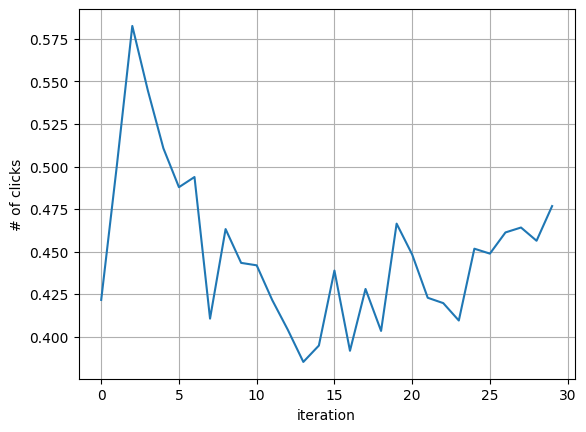

Iteration 29 finished in 8.502745866775513 sec.


In [26]:
metrics = []
for i in range(NUM_ITER):
    print(f'Iteration {i} started')
    iter_time = time.time()
    # выбираем пользователей, которые делают покупки на данной итерации
    current_users = sim.sample_users(0.1).cache()
    # получаем историю их взаимодействия с симулятором в прошлом
    log = sim.get_log(users)

    
    ### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
    recs = model.predict(
        log=log,
        k=K,
        users=current_users,
        items=items,
        filter_seen_items=False
    ).cache()
    ###
    
    assert (recs
            .groupBy('user_idx')
            .agg(sf.count("item_idx").alias("num_items"))
            .filter(sf.col("num_items") == sf.lit(K))
            .count() 
            == 
            current_users.count()
           )
    
    # получаем отклики на рекомендации
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=popularity_model
    ).cache()

    # записываем историю взаимодействия пользователей с рекомендательной системой на этой итерации
    sim.update_log(true_resp, iteration=i)

    # оцениваем качество
    metrics.append(calc_metric(true_resp))

   ### YOUR CODE HERE: дообучите рекомендательную модель на новых данных
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=train_log.select('user_idx', 'item_idx', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    ###

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    plot_metric(metrics)
    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

Посмотреть на результаты работы модели и функции отлика на конкретной итерации можно в log-e симулятора

In [27]:
sim.log.filter(sf.col("__iter") == 1).show(2)

+--------+--------+-------------------+--------+------+
|item_idx|user_idx|          relevance|response|__iter|
+--------+--------+-------------------+--------+------+
|       0|       6|0.08652388167095482|       0|     1|
|       3|       9|0.08787193847894961|       1|     1|
+--------+--------+-------------------+--------+------+
only showing top 2 rows



## Финальный результат

In [28]:
### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
recs = model.predict(
    log=sim.log,
    k=K,
    users=users,
    items=items,
    filter_seen_items=False
).cache()
###

assert (recs
        .groupBy('user_idx')
        .agg(sf.count("item_idx").alias("num_items"))
        .filter(sf.col("num_items") == sf.lit(K))
        .count() == users.count()
       )

In [29]:
# получаем отклики на рекомендации
true_resp = sim.sample_responses(
    recs_df=recs,
    user_features=users,
    item_features=items,
    action_models=popularity_model
).cache()

# оцениваем качество
print(f"Среднее число купленных товаров на пользователя после обучения модели = {calc_metric(true_resp)}")

Среднее число купленных товаров на пользователя после обучения модели = 0.4632


In [30]:
recs.unpersist()
true_resp.unpersist()

DataFrame[item_idx: int, user_idx: int, relevance: double, response: int]

### Посмотрим, что выучила модель

In [31]:
model.item_popularity.orderBy(sf.col('relevance').desc()).show()

+--------+-------------------+
|item_idx|          relevance|
+--------+-------------------+
|       7| 0.6426942790950679|
|       4| 0.6276904449337196|
|       1| 0.6199712623592206|
|       0| 0.4523446432599724|
|       3| 0.4301566395081579|
|       5|0.42857399855599126|
|       9|0.41936286721698335|
|       2| 0.4150649939400617|
|       6|0.40546158206779626|
|       8|0.40372976988823284|
+--------+-------------------+



А такие были истиные значения вероятности отклика на последней итерации:

In [32]:
popularity_model.model.stages[0].get_popularity(iteration=30).orderBy(sf.col('popularity').desc()).show()

+--------+----------+------------+-------------------+
|item_idx|is_popular|is_unpopular|         popularity|
+--------+----------+------------+-------------------+
|       7|         0|           1|                0.7|
|       4|         0|           1|                0.7|
|       1|         0|           1|                0.7|
|       5|         0|           0|                0.4|
|       0|         0|           0|                0.4|
|       9|         0|           0|                0.4|
|       3|         0|           0|                0.4|
|       2|         1|           0|0.15000000000000002|
|       6|         1|           0|0.15000000000000002|
|       8|         1|           0|0.15000000000000002|
+--------+----------+------------+-------------------+



### Исследовательские задачки

1) Проверить работу бандитов из задания 1 в условиях меняющихся предпочтений. Выбрать лучшую модель.
2) Предложить варианты модификации моделей из задания 1 для задачи с меняющимися предпочтениями или предложить другие модели, которые будут наиболее быстро реагировать на изменения в среде